# Exploring Dynamic Time Based TCP Congestion Control (DTBC) Part 2


Let's mimic real world congestion patterns that vary bu time of day. We will adjust our Alpha and Beta dynamically over time by simulating a clock to represent time of the day
During High Traffic hours, we will reduce alpha and increase beta. While during Low Traffic hours, we will increase alpha and decrease beta

Part 2 explores DTBC vs AIMD with scale

## 1. Initialisation

### 1.1) Simulating values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Fixed (for now) 24-hour traffic load
hourly_load = {
    0: 0.5,  1: 0.5,  2: 0.4,  3: 0.4,  4: 0.4,  5: 0.4,
    6: 0.5,  7: 0.6,  8: 0.7,  9: 0.9, 10: 1.0, 11: 1.0,
    12: 1.2, 13: 1.3, 14: 1.3, 15: 1.3, 16: 1.2, 17: 1.1,
    18: 1.0, 19: 0.9, 20: 0.8, 21: 0.7, 22: 0.5, 23: 0.5
}
# Simulate maximum load (50 is fixed for 2 users, will scale accordingly)
C = 50

# This represents network's estimated congestion level (every hour) in a day
# Used to adjust alpha and beta
predicted_demand_factors = np.zeros(24)
for i in range(24):
    predicted_demand_factors[i] = hourly_load[i]

# How many users we want to test
n_users_list = [2, 4, 10, 50, 100, 1000]


### 1.2 Simulate user traffic 
Done over 100 hours for groups of x different users


In [2]:
# Random variation factors
random_variation = 0.1

# Generate user demands for n users over 100 hours
def generate_user_demand(num_users, total_hours=100):
    user_demands = np.zeros((num_users, total_hours))
    avg_demand_ratio = np.linspace(0.5, 0.8, num_users)
    for user in range(num_users):
        avg_demand = C * avg_demand_ratio[user]  # Different demand per user
        for i in range(total_hours):
            hour = i % 24  # Map to hourly load
            base_demand = avg_demand * hourly_load[hour]
            user_demands[user, i] = base_demand * (1 + np.random.uniform(-random_variation, random_variation))
    
    return user_demands


I've also assumed each have a different variation in demand, and slightly different average demand 

### 1.3) Helper function

In [3]:
def compute_utilization(x_values, C):
    """
    Compute utilization and fairness index.
    x_values: np.array of shape (num_users, total_hours, hourly_itr)
    C: Total available bandwidth (scaled per user count)
    """
    num_users, total_hours, hourly_itr = x_values.shape

    # Adjusted C based on user count
    C_scaled = C * (num_users // 2)
    
    # Utilization per time step
    utilization_per_time = np.sum(x_values, axis=0) / C_scaled  # Sum all users, normalize by C
    
    # Average utilization over all hours
    avg_utilization = np.mean(utilization_per_time)
    max_utilization = np.max(utilization_per_time)
    min_utilization = np.min(utilization_per_time)

    # Compute Jain’s Fairness Index
    sum_x = np.sum(x_values, axis=0)  
    sum_x_squared = np.sum(x_values**2, axis=0) 
    fairness_index = (sum_x**2) / (num_users * sum_x_squared)
    avg_fairness = np.mean(fairness_index)
    max_fairness = np.max(fairness_index)
    min_fairness = np.min(fairness_index)

    return utilization_per_time, fairness_index, avg_utilization, max_utilization, min_utilization, avg_fairness, max_fairness, min_fairness


def compute_convergence_iteration(x_values, threshold=0.05, check_window=10):
    """
    Compute the convergence iteration
    
    Parameters:
    x_values (np.array): Congestion window evolution over time (num_users, total_hours, hourly_itr)
    threshold (float): The relative change threshold to define convergence.
    check_window (int): Number of iterations to check stability.
    
    Returns:
    float: Average convergence iteration across users.
    """
    num_users, total_hours, hourly_itr = x_values.shape
    convergence_iterations = np.zeros(num_users)

    for u in range(num_users):
        for t in range(total_hours):
            for i in range(check_window, hourly_itr):
                # Compute relative change in last 'check_window' iterations
                recent_values = x_values[u, t, i - check_window:i]
                relative_change = np.abs(np.diff(recent_values)) / np.maximum(recent_values[:-1], 1e-6)
                
                # Check if all changes are below threshold
                if np.all(relative_change < threshold):
                    convergence_iterations[u] = i
                    break  # Stop once convergence is found

    return np.mean(convergence_iterations) 



## 2) AIMD Algorithm
Adapted and modified from Prof. Tan Chee Wei's Tutorial to fit my needs, and translated to py

In [4]:
def AIMD_algo(users_demand, C, alpha, beta, total_hours=100, hourly_itr=100):
    num_users = users_demand.shape[0]  # Number of users
    C *= (num_users//2)
    x_values = np.zeros((num_users, total_hours, hourly_itr))  # Store AIMD values for all users
    
    for i in range(total_hours):
        x_users = users_demand[:, i]  # Get user demand for current hour        
        for j in range(hourly_itr):
            total_x = np.sum(x_users)  # Compute total demand
            # AIMD Logic
            if total_x <= C:
                x_users += alpha
            else:
                x_users *= beta
            
            # Store values for this iteration
            x_values[:, i, j] = x_users
    
    return x_values

### 2.1) Run AIMD on different number of users

In [5]:
# Run AIMD for different user counts
all_x_values_AIMD = []
for num_users in n_users_list:
    user_demands = generate_user_demand(num_users)
    x_values = AIMD_algo(user_demands, C, alpha=1, beta=0.5)
    all_x_values_AIMD.append(x_values)

    print(f"AIMD simulation completed for {num_users} users.")

AIMD simulation completed for 2 users.
AIMD simulation completed for 4 users.
AIMD simulation completed for 10 users.
AIMD simulation completed for 50 users.
AIMD simulation completed for 100 users.
AIMD simulation completed for 1000 users.


#### 2.2) Compute metrics for AIMD

In [6]:
allUtil_AIMD = []
allFairness_AIMD = []
allAvgUtil_AIMD = []
allAvgFairness_AIMD  = []
allMaxFairness_AIMD  = []
allMinFairness_AIMD  = []
allConvergence_AIMD  = []

for x_values in all_x_values_AIMD:
    util, fairness, avgUtil, maxUtil, minUtil, avgFairness, maxFairness, minFairness = compute_utilization(x_values, C)
    allUtil_AIMD .append(util)
    allFairness_AIMD .append(fairness)
    allAvgUtil_AIMD .append(avgUtil)
    allAvgFairness_AIMD .append(avgFairness)
    allMaxFairness_AIMD .append(maxFairness)
    allMinFairness_AIMD .append(minFairness)
    allConvergence_AIMD .append(compute_convergence_iteration(x_values))

# For better visualisation
results_df = pd.DataFrame({
    'Num Pax': n_users_list,
    'Avg Utilization': allAvgUtil_AIMD ,
    'Avg Fairness': allAvgFairness_AIMD ,
    'Max Fairness': allMaxFairness_AIMD ,
    'Min Fairness': allMinFairness_AIMD ,
    'Convergence': allConvergence_AIMD 
})

# Print the formatted table
print(results_df)


   Num Pax  Avg Utilization  Avg Fairness  Max Fairness  Min Fairness  \
0        2         0.774481      0.995261      0.999999      0.915223   
1        4         0.774508      0.996782      0.999999      0.949701   
2       10         0.774733      0.997508      0.999999      0.963801   
3       50         0.774277      0.997818      0.999999      0.973168   
4      100         0.774023      0.997924      0.999999      0.975511   
5     1000         0.773666      0.997946      0.999999      0.978028   

   Convergence  
0        5.000  
1        5.750  
2        3.200  
3        2.900  
4        2.790  
5        2.762  


## 3) Dynamic Time Based congestion Control (DTBC)
Our new time based dynamic algiorhtm to control additive and decrease

In [7]:
def DTBC_algo(userDemands, predictedDemandFactor, C, alpha, beta, total_hours=100, hourly_itr=100):
    """
    Implements the Dynamic Time-Based Congestion (DTBC) control algorithm for multiple users.

    This function dynamically adjusts alpha and beta based on predicted demand and simulates 
    bandwidth allocation for multiple users over time.

    Parameters:
    userDemands (np.array): A 3D array of shape (num_users, total_hours) representing user demands.
    predictedDemandFactor (np.array): An array of length 24 representing demand scaling factors per hour.
    C (int): Total available bandwidth.
    alpha (float): Base additive increase factor.
    beta (float): Base multiplicative decrease factor.
    total_hours (int): Number of hours to simulate.
    hourly_itr (int): Number of iterations per hour.

    Returns:
    np.array: A 3D matrix (num_users, total_hours, hourly_itr) containing congestion window values.
    """
    num_users = userDemands.shape[0]
    C *= (num_users//2)
    x_values_hourly = np.zeros((num_users, total_hours, hourly_itr))
    
    # Keep original alpha/beta values as they are dynamically scaled
    originalAlpha = alpha
    originalBeta = beta

    for i in range(total_hours):
        # Get user demand for the current hour for all users
        x_values = userDemands[:, i].copy()
        
        # Simulate time of day (0-23 hours repeating every 24 iterations)
        time_of_the_day = i % 24
        curPredictedDemandFactor = predictedDemandFactor[time_of_the_day]

        # Adjust AIMD parameters based on current predicted demand
        alpha = originalAlpha / curPredictedDemandFactor  # Higher demand → Higher increase rate; vice versa
        beta = 1 - ((1 - originalBeta) * curPredictedDemandFactor)  # Lower demand → Smaller decrease rate; vice versa
        
        for j in range(hourly_itr):
            # Additive Increase
            if np.sum(x_values) <= C: 
                x_values += alpha 
            # Multiplicative Decrease
            else: 
                x_values *= beta
            
            # Store values
            x_values_hourly[:, i, j] = x_values
    
    return x_values_hourly


### 3.1) Running DTBC

In [8]:
# Run AIMD for different user counts
all_x_values_DTBC = []
for num_users in n_users_list:
    user_demands = generate_user_demand(num_users)
    x_values = DTBC_algo(user_demands, predicted_demand_factors, C, alpha=1, beta=0.5)
    all_x_values_DTBC.append(x_values)

    print(f"DTBC simulation completed for {num_users} users.")

DTBC simulation completed for 2 users.
DTBC simulation completed for 4 users.
DTBC simulation completed for 10 users.
DTBC simulation completed for 50 users.
DTBC simulation completed for 100 users.
DTBC simulation completed for 1000 users.


### 3.2) Compute Metrics for DTBC

In [9]:
# Compute utilization and fairness for DTBC
allAvgUtil_DTBC = []
allAvgFairness_DTBC = []
allMaxFairness_DTBC = []
allMinFairness_DTBC = []
allConvergence_DTBC  = []

for x_values in all_x_values_DTBC:
    avgUtil, maxUtil, minUtil, avgFairness, maxFairness, minFairness = compute_utilization(x_values, C)[2:]
    allAvgUtil_DTBC .append(avgUtil)
    allAvgFairness_DTBC .append(avgFairness)
    allMaxFairness_DTBC .append(maxFairness)
    allMinFairness_DTBC .append(minFairness)
    allConvergence_DTBC .append(compute_convergence_iteration(x_values))

# For better visualisation
results_df = pd.DataFrame({
    'Num Pax': n_users_list,
    'Avg Utilization': allAvgUtil_DTBC ,
    'Avg Fairness': allAvgFairness_DTBC ,
    'Max Fairness': allMaxFairness_DTBC ,
    'Min Fairness': allMinFairness_DTBC ,
    'Convergence': allConvergence_DTBC 
})

print(results_df)

   Num Pax  Avg Utilization  Avg Fairness  Max Fairness  Min Fairness  \
0        2         0.821649      0.995549           1.0      0.912641   
1        4         0.821292      0.997446           1.0      0.949870   
2       10         0.821037      0.997997           1.0      0.962947   
3       50         0.820912      0.998280           1.0      0.976065   
4      100         0.820982      0.998287           1.0      0.974791   
5     1000         0.820893      0.998314           1.0      0.977931   

   Convergence  
0       30.000  
1       25.750  
2       22.900  
3       20.700  
4       19.640  
5       20.613  


## 4) Comparison between 2 algorithms

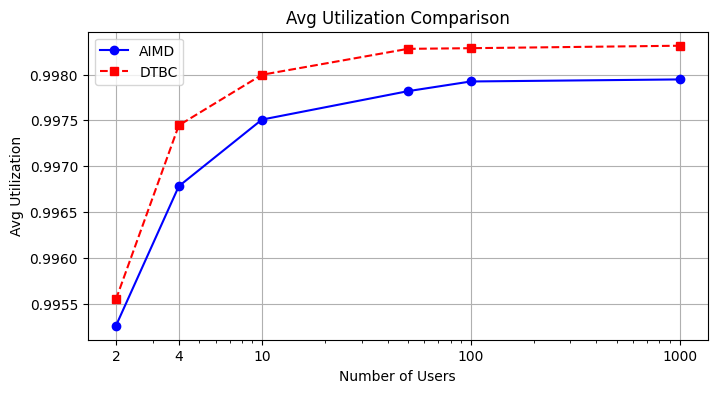

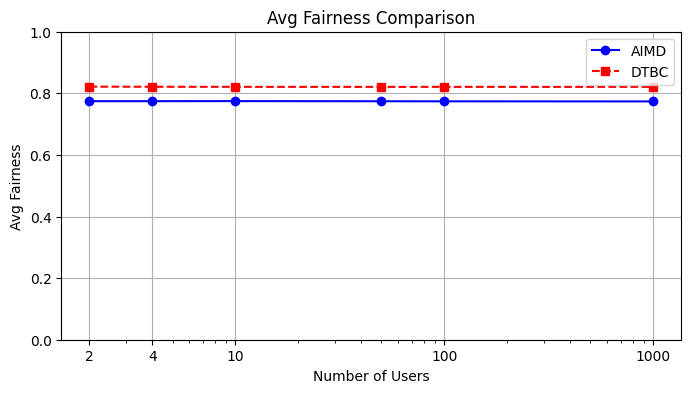

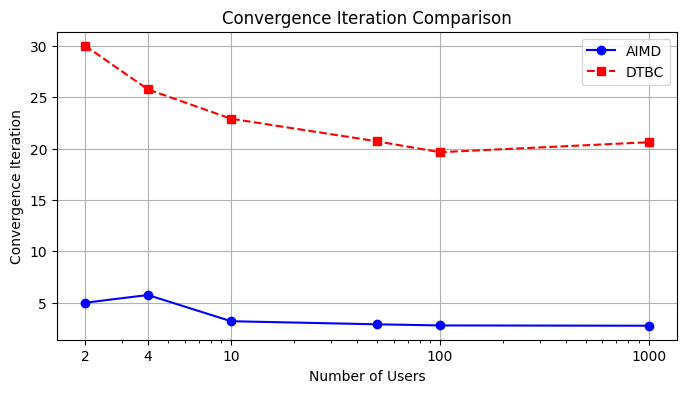

In [10]:
# Utilization Comparison
plt.figure(figsize=(8, 4))
plt.plot(n_users_list, allAvgFairness_AIMD, marker='o', linestyle='-', color='blue', label='AIMD')
plt.plot(n_users_list, allAvgFairness_DTBC, marker='s', linestyle='--', color='red', label='DTBC')
plt.xscale('log')
plt.xticks([2, 4, 10, 100, 1000], labels=['2', '4', '10', '100', '1000'])
plt.xlabel('Number of Users')
plt.ylabel('Avg Utilization')
plt.title('Avg Utilization Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Fairness Comparison
plt.figure(figsize=(8, 4))
plt.plot(n_users_list, allAvgUtil_AIMD, marker='o', linestyle='-', color='blue', label='AIMD')
plt.plot(n_users_list, allAvgUtil_DTBC, marker='s', linestyle='--', color='red', label='DTBC')
plt.xscale('log')
plt.xticks([2, 4, 10, 100, 1000], labels=['2', '4', '10', '100', '1000'])
plt.ylim(0,1)
plt.xlabel('Number of Users')
plt.ylabel('Avg Fairness')
plt.title('Avg Fairness Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Convergence Iteration Comparison
plt.figure(figsize=(8, 4))
plt.plot(n_users_list, allConvergence_AIMD, marker='o', linestyle='-', color='blue', label='AIMD')
plt.plot(n_users_list, allConvergence_DTBC, marker='s', linestyle='--', color='red', label='DTBC')
plt.xscale('log')
plt.xticks([2, 4, 10, 100, 1000], labels=['2', '4', '10', '100', '1000'])
plt.xlabel('Number of Users')
plt.ylabel('Convergence Iteration')
plt.title('Convergence Iteration Comparison')
plt.legend()
plt.grid(True)
plt.show()